In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt
%matplotlib ipympl

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
from data_loader import DataLoader
from utils import *
from mcs_function import *
from plotting import *
import config
import pickle
import pmcx
import matplotlib.pyplot as plt
from mbll_functions import *
import pandas as pd
import scipy
import pickle
from tqdm.notebook import tqdm

In [4]:
pmcx.gpuinfo()

=============================   GPU Information  ================================
Device 1 of 1:		NVIDIA GeForce GTX 1050
Compute Capability:	6.1
Global Memory:		4229824512 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.49 GHz
Number of SMs:		5
Number of Cores:	640
Auto-thread:		10240
Auto-block:		64


[{'name': 'NVIDIA GeForce GTX 1050',
  'id': 1,
  'devcount': 1,
  'major': 6,
  'minor': 1,
  'globalmem': 4229824512,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1493000,
  'sm': 5,
  'core': 640,
  'autoblock': 64,
  'autothread': 10240,
  'maxgate': 0}]

In [5]:
config.gpuid

1

In [6]:
config.simulated_dataset_dir

PosixPath('/media/leon/T7/IDP/dataset/simulated')

Determine tumor parameters via linear least squares from attenuation data.

In [7]:
#tumor_df = pd.read_excel(
#    config.spectra_dir / "tumor_optical_properties.xlsx",
#    sheet_name="HGG_fresh", # high-grade glioma, fresh
#)
tumor_df = pd.read_excel(
    config.spectra_dir / "tumor_optical_properties.xlsx",
    sheet_name="HGG_comparison"
)
tumor_df_wavelength_condition = (tumor_df["Wavelength"] >= 400) & (tumor_df["Wavelength"] <= 1000) 
tumor_absorption_spectrum = tumor_df.loc[tumor_df_wavelength_condition, "mua_Gebhart_frozen_freshly_excised_snapfrozen"].to_numpy() * 10
tumor_scattering_spectrum = tumor_df.loc[tumor_df_wavelength_condition, "mus_fitted_present_fresh_30mins"].to_numpy() * 10
wavelengths_tumor = tumor_df.loc[tumor_df_wavelength_condition, "Wavelength"].to_numpy()

In [8]:
mu_a_tumor = DataLoader.absorption_coefs(
    wavelengths_tumor,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [9]:
res = scipy.optimize.lsq_linear(
    mu_a_tumor,
    tumor_absorption_spectrum,
    bounds=(
        [0, 0, 0, 0, 0, 0],
        [1, 1, 0.1, 0.1, 1, 1]
    )
)
tumor_base_concentrations = res.x
print(tumor_base_concentrations)
print(DataLoader.tissue_parameters["gray matter"][0])

[2.63917345e-02 4.97132978e-28 5.07849077e-02 2.20338712e-27
 1.00000000e+00 1.50039964e-25]
[0.0646 0.0114 0.0064 0.0016 0.73   0.1   ]


The oxCCO value seems much to high. There might be another chromophore that I am not accounting for. I will instead simply use tissue concentrations as for white matter. White matter tissue was reported to have very similar absorption spectra to brain tumor.

In [10]:
tissue_types = ["gray matter", "artery", "vein", "tumor"]

In [14]:
# simulated tissue concentrations
simulation_data = dict()
for tissue_type in tissue_types: #DataLoader.tissue_parameters.keys():
    base_concentrations = DataLoader.tissue_parameters[tissue_type][0]
    base_concentrations_blood_fraction = concentrations_to_blood_fraction(base_concentrations)
    base_scattering_params = DataLoader.tissue_parameters[tissue_type][1]
    std_dev_concentrations_blood_fraction = np.array([0.015, 0.015, 5e-4, 5e-4, 0.015, 0.015])
    sampled_concentrations_blood_fraction = np.random.normal(
        loc=base_concentrations_blood_fraction,
        scale=std_dev_concentrations_blood_fraction,
        size=(9,6)
    )
    std_dev_scattering = np.array([5, 0.15])
    sampled_scattering_params = np.random.normal(
        loc=base_scattering_params,
        scale=std_dev_scattering,
        size=(9,2)
    )
    # clip values
    sampled_concentrations_blood_fraction = np.clip(sampled_concentrations_blood_fraction, a_min=[[0, 0, 0, 0, 0, 0]], a_max=[[1, 1, np.inf, np.inf, 1, 1]])
    # (#molecules, #spectra)
    sampled_concentrations = blood_fraction_to_concentrations(sampled_concentrations_blood_fraction.T)
    sampled_scattering_params = np.clip(sampled_scattering_params, a_min=[[0, 0]], a_max=[[200, 10]]).T
    # first value is baseline, second should have full perturbation of standard_deviation
    sampled_concentrations = np.column_stack(
        (
         base_concentrations,
         blood_fraction_to_concentrations(base_concentrations_blood_fraction + std_dev_concentrations_blood_fraction),
         sampled_concentrations
        )
    )
    sampled_scattering_params = np.column_stack((base_scattering_params, (base_scattering_params + std_dev_scattering), sampled_scattering_params))
    simulation_data[tissue_type] = (sampled_concentrations, sampled_scattering_params)

In [15]:
simulation_data["gray matter"][0].shape

(6, 11)

In [16]:
simulation_data["tumor"][0]

array([[3.23000000e-02, 6.30444186e-02, 6.24326509e-03, 0.00000000e+00,
        3.00481421e-02, 5.60046474e-03, 3.16458477e-02, 2.98001208e-02,
        1.98321840e-02, 6.00416970e-04, 3.30560475e-02],
       [5.70000000e-03, 9.83930233e-03, 1.31659329e-03, 0.00000000e+00,
        5.50843213e-03, 8.63822211e-04, 5.79065534e-03, 4.94305592e-03,
        3.26574119e-03, 9.71244416e-05, 6.46664247e-03],
       [3.20000000e-03, 3.70000000e-03, 3.70338059e-03, 3.30850101e-03,
        3.72693942e-03, 3.97485645e-03, 3.47923006e-03, 3.64565876e-03,
        2.50865122e-03, 3.31328447e-03, 2.02868760e-03],
       [8.00000000e-04, 1.30000000e-03, 5.19474990e-04, 8.68956622e-04,
        1.08308910e-03, 1.73420920e-03, 9.33775224e-04, 3.01175486e-04,
        6.80086574e-04, 1.25816871e-03, 8.77626077e-04],
       [3.65000000e-01, 3.80000000e-01, 3.71836030e-01, 3.65190774e-01,
        3.95798412e-01, 3.67988938e-01, 3.59283208e-01, 3.56406363e-01,
        3.56540235e-01, 3.84495611e-01, 3.67009428e-

MCX Configuration

In [ ]:
# empty log file
open(config.simulated_dataset_dir / "log.txt", "w").close()
vol = np.ones((60, 60, 120), dtype="uint8")

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": vol,
    "tstart":0,
    "tend":3e-7,
    "tstep":3e-7,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "bc": "ccrcca",#001000",
    #"isspecular": 1,
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    #"savedetflag": "dpx",
    "flog": str(config.simulated_dataset_dir) + "/log.txt",
    "isnormalized": 0,
    "issaveref": 1
}

# necessary to accumulate weights
cfg["vol"][:, :, 0] = 0

In [18]:
wavelengths = np.arange(520, 920, 15)
mu_a_matrix = DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [19]:
print(wavelengths)
print(len(wavelengths))

[520 535 550 565 580 595 610 625 640 655 670 685 700 715 730 745 760 775
 790 805 820 835 850 865 880 895 910]
27


In [20]:
%%time
for tissue_type in tissue_types:
    print(f"----------------Tissue Type: {tissue_type}------------------")
    tissue_spectra = []
    g, refractive_idx = DataLoader.tissue_parameters[tissue_type][-2:]
    for spectrum_idx in tqdm(range(simulation_data[tissue_type][0].shape[-1])):
        concentrations = simulation_data[tissue_type][0][:, spectrum_idx]
        scattering_params = simulation_data[tissue_type][1][:, spectrum_idx]
        mu_a_vals = mu_a_matrix @ concentrations
        mu_s_red_vals = scattering_params[0] * (wavelengths / 500) ** (-scattering_params[1])
        mu_a_vals /= 10
        mu_s_red_vals /= 10
        spectrum = []
        for mu_a, mu_s_red in zip(mu_a_vals, mu_s_red_vals):
            cfg["prop"] = np.array([
                [0, 0, 1, 1],
                [mu_a, mu_s_red / (1-g), g, refractive_idx]
            ])
            res = pmcx.mcxlab(cfg)
            dref = np.sum(res["dref"][:, :, 0, :]) / cfg["nphoton"]
            spectrum.append(-np.log(dref))
        tissue_spectra.append(spectrum)
    # notice the .T => store as (wavelengths, spectra)
    simulation_data[tissue_type] = simulation_data[tissue_type][:2] + (np.array(tissue_spectra).T,)

----------------Tissue Type: gray matter------------------


  0%|          | 0/11 [00:00<?, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
=============================   GPU Information  ================================
Device 1 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.77 GHz
Number of SMs:		72
Number of Cores:	4608
Auto-thread:		147456
Auto-block:		64
=============================   GPU Information  ================================
Device 2 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.77 GHz
Number of SMs:		72
Number of Cores:	4608
Auto-thread:		147456
Auto-block:		64
=============================   GPU Information  ================================
Device 3 of 8:		Quadro RTX 8000
Compute Capability:	7.5
Global Memory:		50953846784 B
Constant Memory:	655

  0%|          | 0/11 [00:00<?, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstar

  0%|          | 0/11 [00:00<?, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstar

  0%|          | 0/11 [00:00<?, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 3e-07
tend: 3e-07
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
nphoton: 1e+07
tstar

Save data to file...

In [21]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "wb") as f:
    pickle.dump((wavelengths, simulation_data), f)

In [7]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

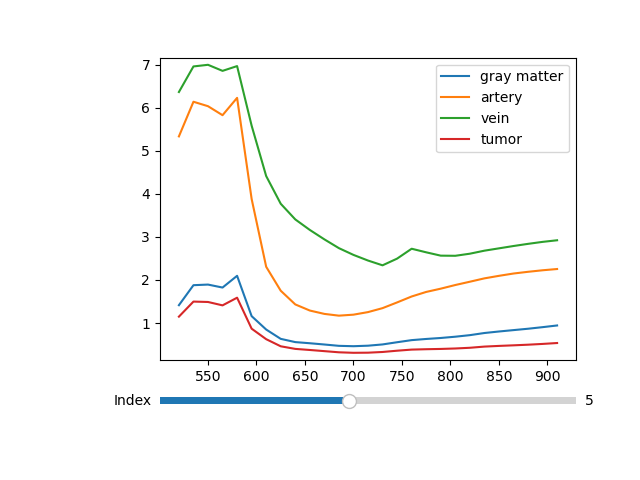

In [8]:
tissue_types = ["gray matter", "artery", "vein", "tumor"]
plot_spectra_slider(
    np.concatenate([simulation_data[tissue_type][-1][None, ...] for tissue_type in tissue_types], axis=0),
    wavelengths,
    labels=tissue_types
)